In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import copy
from datetime import datetime, timedelta
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import brier_score_loss
from sklearn.metrics import make_scorer
from sklearn.utils.class_weight import compute_class_weight
import sys
import os
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
import glob 


from sklearn import datasets, ensemble
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.utils import class_weight
import json

import xgboost as xgb
from bayes_opt import BayesianOptimization
import shap
from sklearn.preprocessing import MinMaxScaler

/glade/work/jhayron/conda-envs/pytorch_wr/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_train_val_test_periods(full_df):
    dic_train_val = {}
    dic_test = {}
    
    start_of_test_periods = np.arange(1981,2021,10)
    end_of_test_periods = start_of_test_periods + 9
    
    for iperiod in range(len(start_of_test_periods)):
        df_test_temp = full_df[str(start_of_test_periods[iperiod]):str(end_of_test_periods[iperiod])]
        df_trainval_temp = full_df.drop(df_test_temp.index)
        
        dic_train_val[start_of_test_periods[iperiod]] = df_trainval_temp
        dic_test[start_of_test_periods[iperiod]] = df_test_temp
    return dic_train_val, dic_test

In [3]:

def generate_random_forecast(df_week_0, seed_value=42):
    # Set the random seed for reproducibility
    np.random.seed(seed_value)
    
    # Step 1: Get unique classes and their frequencies
    values = df_week_0[df_week_0.keys()[0]].value_counts()
    
    # Step 2: Calculate the probabilities for each class
    classes = values.index  # Unique classes
    probabilities = values / values.sum()  # Normalize to get probability distribution
    
    # Step 3: Generate a random forecast based on the probabilities
    random_forecast = np.random.choice(classes, size=len(df_week_0), p=probabilities)
    
    # Step 4: Return the random forecast as a DataFrame or Series
    forecast_df = pd.DataFrame(random_forecast, index=df_week_0.index, columns=['y_predicted'])
    
    return forecast_df

def generate_random_forecast_probabilities(df_week_0, seed_value=42):
    # Set the random seed for reproducibility
    np.random.seed(seed_value)
    # Step 1: Get unique classes and their frequencies
    values = df_week_0[df_week_0.keys()[0]].value_counts()
    
    # Step 2: Calculate the probabilities for each class
    classes = values.index  # Unique classes
    probabilities = values / values.sum()  # Normalize to get probability distribution
    
    # Step 3: Create a probability forecast for each sample
    # Create a 2D array where each row is the same probability distribution
    prob_matrix = np.tile(probabilities.values, (len(df_week_0), 1))
    
    # Step 4: Return the probability matrix as a DataFrame
    forecast_df = pd.DataFrame(prob_matrix, index=df_week_0.index, columns=classes)[np.arange(len(classes))]
    
    return forecast_df

def generate_random_forecast_with_monthly_probabilities(df_week_0, seed_value=42):
    # Set the random seed for reproducibility
    np.random.seed(seed_value)
    
    # Extract the month from the index (assuming the index is a datetime index)
    df_week_0['month'] = df_week_0.index.month
    
    # Prepare an empty list to store the random forecast
    forecasts = []
    
    # Loop through each month
    for month in range(1, 13):  # Loop through months 1 to 12
        # Filter data for the current month
        month_data = df_week_0[df_week_0['month'] == month]
        
        # Step 1: Get unique classes and their frequencies for the current month
        values = month_data[df_week_0.keys()[0]].value_counts()
        
        # Step 2: Calculate the probabilities for each class in the current month
        classes = values.index  # Unique classes
        probabilities = values / values.sum()  # Normalize to get probability distribution
        
        # Step 3: Generate random forecasts for the current month based on the probabilities
        month_forecast = np.random.choice(classes, size=len(month_data), p=probabilities)
        
        # Store the forecast for the current month
        forecasts.append(pd.Series(month_forecast, index=month_data.index))
    
    # Combine all monthly forecasts into one DataFrame
    forecast_df = pd.concat(forecasts)
    forecast_df = forecast_df.sort_index()  # Sort the index to preserve the original order
    forecast_df = pd.DataFrame(forecast_df,columns=['y_predicted'])
    return forecast_df
    
def generate_probability_forecast_with_monthly_probabilities(df_week_0, seed_value=42):
    # Set the random seed for reproducibility
    np.random.seed(seed_value)
    
    # Extract the month from the index (assuming the index is a datetime index)
    df_week_0['month'] = df_week_0.index.month
    
    # Prepare an empty DataFrame to store the probability forecasts
    all_probabilities = pd.DataFrame(index=df_week_0.index)
    
    # Loop through each month
    for month in range(1, 13):  # Loop through months 1 to 12
        # Filter data for the current month
        month_data = df_week_0[df_week_0['month'] == month]
        
        if month_data.empty:
            continue  # Skip if there's no data for the month
        
        # Step 1: Get unique classes and their frequencies for the current month
        values = month_data[df_week_0.keys()[0]].value_counts()
        
        # Step 2: Calculate the probabilities for each class in the current month
        classes = values.index  # Unique classes
        probabilities = values / values.sum()  # Normalize to get probability distribution
        
        # Step 3: Create a probability matrix for the current month
        prob_matrix = np.tile(probabilities.values, (len(month_data), 1))
        
        # Create a DataFrame for this month's probabilities with appropriate columns
        month_prob_df = pd.DataFrame(prob_matrix, index=month_data.index, columns=classes)
        
        # Append this month's DataFrame to the overall probability DataFrame
        all_probabilities = pd.concat([all_probabilities, month_prob_df])
    
    # Sort the index to match the original order
    all_probabilities = all_probabilities.sort_index()
    
    # Fill missing columns with zeros for months that do not include certain classes
    all_classes = df_week_0[df_week_0.keys()[0]].unique()
    all_probabilities = all_probabilities.reindex(columns=all_classes, fill_value=0).dropna()[np.arange(len(classes))]
    
    return all_probabilities

In [4]:
import os

# Run nvidia-smi to get GPU information
os.system('nvidia-smi')

Wed Dec 25 13:56:31 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  |   00000000:81:00.0 Off |                    0 |
| N/A   32C    P0             61W /  500W |       9MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

0

In [5]:
gpu_id = 0

# 1. 5 classes

In [35]:
wr_original_series = pd.read_csv('/glade/work/jhayron/Data4Predictability/WR_Series_vSLtest.csv',\
                index_col=0,names=['week0','dist'],skiprows=1,parse_dates=True)
# Rolling window for mode
rolling_mode = (
    wr_original_series.rolling('7d', center=True,min_periods=7)
    .apply(lambda x: x.mode()[0] if not x.mode().empty else float('nan'))
).shift(-3)

# Rolling window for the count of the mode
rolling_mode_count = (
    wr_original_series.rolling('7d', center=True,min_periods=7)
    .apply(lambda x: (x == x.mode()[0]).sum() if not x.mode().empty else 0)
).shift(-3)

# If duration of WR during week was less than 4, assing NO WR class
rolling_mode.loc[rolling_mode_count['week0']<4,'week0'] = 4
wr_series_mode = copy.deepcopy(rolling_mode)
time_index = pd.to_datetime(wr_series_mode.index).dayofweek
wr_series_mode = wr_series_mode.iloc[time_index.isin([0,3])].dropna()
wr_series = copy.deepcopy(wr_series_mode)

for wk in range(2,10):
    series_temp = copy.deepcopy(wr_series["week0"])
    series_temp.index = series_temp.index - timedelta(weeks = wk-1)
    series_temp.name = f'week{wk-1}'
    if wk==2:
        df_shifts = pd.concat([pd.DataFrame(wr_series["week0"]),pd.DataFrame(series_temp)],axis=1)  
    else:
        df_shifts = pd.concat([df_shifts,pd.DataFrame(series_temp)],axis=1)

In [36]:
list_files_anoms = np.sort(glob.glob('/glade/derecho/scratch/jhayron/Data4Predictability/WeeklyAnoms_DetrendedStd_v3_2dg/*.nc'))
list_vars = [list_files_anoms[i].split('/')[-1][:-3] for i in range(len(list_files_anoms))]

In [37]:
for ivar,var in enumerate(list_vars):
    print(ivar,var)

0 IC_SODA
1 IT_SODA
2 MLD_SODA
3 OHC100_SODA
4 OHC200_SODA
5 OHC300_SODA
6 OHC50_SODA
7 OHC700_SODA
8 OLR_ERA5
9 SD_ERA5
10 SSH_SODA
11 SST_OISSTv2
12 SST_SODA
13 STL_1m_ERA5
14 STL_28cm_ERA5
15 STL_7cm_ERA5
16 STL_full_ERA5
17 SWVL_1m_ERA5
18 SWVL_28cm_ERA5
19 SWVL_7cm_ERA5
20 SWVL_full_ERA5
21 U10_ERA5
22 U200_ERA5
23 Z500_ERA5


In [38]:
ivar = 3

In [39]:
def f1_eval(preds, dtrain):
    labels = dtrain.get_label()
    preds = np.argmax(preds, axis=1)  # Get the predicted class
    f1 = f1_score(labels, preds, average='micro')
    return 'f1_eval', f1

In [40]:
print(list_vars[ivar])

path_weekly_anoms = '/glade/derecho/scratch/jhayron/Data4Predictability/WeeklyAnoms_DetrendedStd_v2_2dg/'
path_nc_anoms = f'{path_weekly_anoms}{list_vars[ivar]}.nc'
anoms = xr.open_dataset(path_nc_anoms)
anoms = anoms.assign_coords(time=pd.DatetimeIndex(anoms.time).normalize())
var_name_nc = list(anoms.data_vars.keys())[0]

# Define a boxcar filter function
def boxcar_filter(data, size):
    kernel = np.ones((size, size)) / (size * size)
    from scipy.signal import convolve2d
    return convolve2d(data, kernel, mode="same", boundary="fill", fillvalue=np.nan)

# Apply boxcar filter
smoothed_anoms = xr.apply_ufunc(
    boxcar_filter,
    anoms,
    kwargs={"size": 3},  # Adjust window size (e.g., 5x5 grid cells)
    input_core_dims=[["lat", "lon"]],
    output_core_dims=[["lat", "lon"]],
    vectorize=True,
)

anoms_flattened = smoothed_anoms[var_name_nc].stack(flat_spatial=('lat', 'lon'))
anoms_flattened_og = copy.deepcopy(anoms_flattened)
# anoms_flattened_og.data[:,anoms_flattened.columns] = anoms_flattened.values WITH THIS LINES I CAN COME BACK
# anoms_flattened_og.unstack('flat_spatial') WITH THIS LINES I CAN COME BACK
anoms_flattened = pd.DataFrame(anoms_flattened,index = anoms_flattened.time)
anoms_flattened = anoms_flattened.dropna(axis=1, how='any')

combined_df = copy.deepcopy(anoms_flattened)
combined_df['day_sin'] = np.sin(2 * np.pi * combined_df.index.day_of_year / 365)
combined_df['day_cos'] = np.cos(2 * np.pi * combined_df.index.day_of_year / 365)


OHC100_SODA


In [41]:
f1s_test = []
f1s_random = []
f1s_persistence = []
f1s_climatology = []

for week_out in range(0,9):
    print(f'WEEK: {week_out}')
    week_out_str = f'week{week_out}'

    fully_combined_df = pd.concat([combined_df,df_shifts[week_out_str]],axis=1)
    fully_combined_df = fully_combined_df.dropna()
    dic_trainval, dic_test = get_train_val_test_periods(fully_combined_df)
    start_of_test_periods = np.arange(1981,2021,10)
    
    df_week_forecast = df_shifts[[week_out_str]].dropna()
    
    random_forecast = generate_random_forecast(df_week_forecast, seed_value=42)
    climatology_forecast = generate_random_forecast_with_monthly_probabilities(df_week_forecast, seed_value=42)
    random_forecast_probs = generate_random_forecast_probabilities(df_week_forecast)
    climatology_forecast_probs = generate_probability_forecast_with_monthly_probabilities(df_week_forecast)
    
    list_results = []
    list_results_probs = []
    
    for iperiod in range(len(start_of_test_periods)):
        print(iperiod)
        X_trainval = dic_trainval[start_of_test_periods[iperiod]].iloc[:,:-1].values
        y_trainval = dic_trainval[start_of_test_periods[iperiod]].iloc[:,-1]
        
        X_test = dic_test[start_of_test_periods[iperiod]].iloc[:,:-1].values
        y_test = dic_test[start_of_test_periods[iperiod]].iloc[:,-1]
        #### HERE DEFINITION OF THE MODEL ####
        hyperparams = {
            "n_estimators": 100,       # Number of boosting rounds, balances speed and depth
            "max_depth": 15,            # Controls tree depth; deeper trees model complexity better but risk overfitting
            "learning_rate": 0.1,      # Step size shrinkage for reducing overfitting risk
            "subsample": 0.8,          # Fraction of training samples used per tree, helps generalize
            "colsample_bytree": 0.8,   # Fraction of features used per tree, improves robustness
            "gamma": 0,                # Minimum loss reduction to make a split, prevents overfitting
            "min_child_weight": 1,     # Minimum sum of instance weight needed in a leaf, controls complexity
            "reg_alpha": 0,            # L1 regularization term for weights, often fine at 0 unless high sparsity is needed
            "reg_lambda": 1            # L2 regularization term for weights, controls overfitting
        }
        cw = class_weight.compute_sample_weight(
            class_weight='balanced',
            y=y_trainval
        )
        cw = cw**0.5
        model = xgb.XGBClassifier(n_estimators=100,
                            max_depth=hyperparams['max_depth'],
                            learning_rate=hyperparams['learning_rate'],
                            subsample=hyperparams['subsample'],
                            colsample_bytree=hyperparams['colsample_bytree'],
                            # colsample_bylevel=best_params['colsample_bylevel'],
                            gamma=hyperparams['gamma'],
                            reg_alpha=hyperparams['reg_alpha'],
                            reg_lambda=hyperparams['reg_lambda'],
                            num_class=5,
                            objective = "multi:softprob",
                            tree_method='hist',
                            device = f'cuda:{gpu_id}')
        model.fit(X_trainval, y_trainval, sample_weight=cw)
        y_predicted = model.predict(X_test)
        print(f1_score(y_test,y_predicted,average='micro'))
        y_predicted_probs = model.predict_proba(X_test)
        y_predicted_probs = pd.DataFrame(y_predicted_probs,index=y_test.index)
        df_results_temp = pd.DataFrame(np.array([y_test.values,y_predicted]).T,
                                       index=y_test.index,
                                       columns=['y_true','y_predicted'])
        list_results.append(df_results_temp)
        list_results_probs.append(y_predicted_probs)
        
    df_results_full = pd.concat(list_results,axis=0)
    df_results_probs_full = pd.concat(list_results_probs,axis=0)
    print('**** Micro results ****')
    f1_results = f1_score(df_results_full['y_true'],df_results_full['y_predicted'],average='micro')
    
    f1_random = f1_score(df_results_full['y_true'],
             random_forecast['y_predicted'].loc[df_results_full['y_true'].index],average='micro')
    df_week_0 = df_shifts[['week0']].dropna()
    persistence_forecast = df_week_0.loc[df_results_full['y_true'].index]
    f1_persistence = f1_score(df_results_full['y_true'],
             persistence_forecast['week0'].loc[df_results_full['y_true'].index],average='micro')
    
    f1_climatology = f1_score(df_results_full['y_true'],
             climatology_forecast['y_predicted'].loc[df_results_full['y_true'].index],average='micro')
    print(f'F1 XGBoost:', f1_results)
    print('F1 Random:',f1_random)
    print('F1 Persistence:',f1_persistence)
    print('F1 Climatology:',f1_climatology)
    f1s_test.append(f1_results)
    f1s_random.append(f1_random)
    f1s_persistence.append(f1_persistence)
    f1s_climatology.append(f1_climatology)

WEEK: 0
0
0.286673058485139
1
0.2224352828379674
2
0.27873563218390807
3
0.23597678916827852
**** Micro results ****
F1 XGBoost: 0.25600384245917385
F1 Random: 0.20317002881844382
F1 Persistence: 1.0
F1 Climatology: 0.21181556195965417
**** Macro results ****
F1 XGBoost: 0.23115379984061324
F1 Random: 0.19660035116071647
F1 Persistence: 1.0
F1 Climatology: 0.20477719472627412
WEEK: 1
0
0.22914669223394055
1
0.19271332694151486
2
0.22413793103448276
3
0.2369439071566731
**** Micro results ****
F1 XGBoost: 0.2207012487992315
F1 Random: 0.20317002881844382
F1 Persistence: 0.33549471661863595
F1 Climatology: 0.21517771373679154
**** Macro results ****
F1 XGBoost: 0.19243506482039124
F1 Random: 0.1966026319614781
F1 Persistence: 0.32454957187980527
F1 Climatology: 0.2091258310003961
WEEK: 2
0
0.2473633748801534
1
0.24352828379674019
2
0.2078544061302682
3
0.20696324951644102
**** Micro results ****
F1 XGBoost: 0.22646493756003844
F1 Random: 0.20317002881844382
F1 Persistence: 0.240874159462

Text(0.5, 0, 'Lead time')

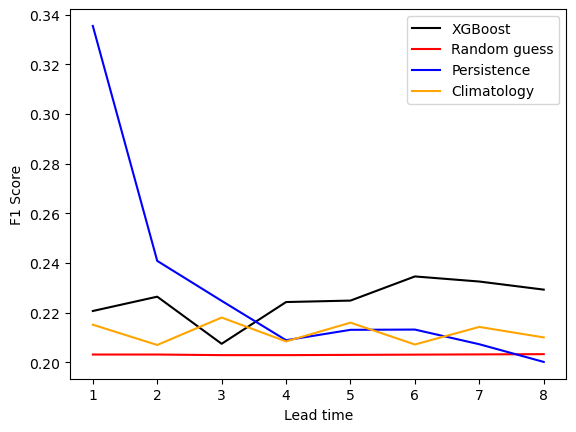

In [42]:
# dataset v3
plt.plot(np.arange(1,9),f1s_test[1:],color='k',label='XGBoost')
plt.plot(np.arange(1,9),f1s_random[1:],color='red',label='Random guess')
plt.plot(np.arange(1,9),f1s_persistence[1:],color='blue',label='Persistence')
plt.plot(np.arange(1,9),f1s_climatology[1:],color='orange',label='Climatology')
plt.legend()
plt.ylabel('F1 Score')
plt.xlabel('Lead time')

# 2. 4 Classes

In [16]:
wr_original_series = pd.read_csv('/glade/work/jhayron/Data4Predictability/WR_Series_vSLtest.csv',\
                index_col=0,names=['week0','dist'],skiprows=1,parse_dates=True)
# Rolling window for mode
rolling_mode = (
    wr_original_series.rolling('7d', center=True,min_periods=7)
    .apply(lambda x: x.mode()[0] if not x.mode().empty else float('nan'))
).shift(-3)

# Rolling window for the count of the mode
rolling_mode_count = (
    wr_original_series.rolling('7d', center=True,min_periods=7)
    .apply(lambda x: (x == x.mode()[0]).sum() if not x.mode().empty else 0)
).shift(-3)

# If duration of WR during week was less than 4, assing NO WR class
rolling_mode.loc[rolling_mode_count['week0']<4,'week0'] = 4
wr_series_mode = copy.deepcopy(rolling_mode)
time_index = pd.to_datetime(wr_series_mode.index).dayofweek
wr_series_mode = wr_series_mode.iloc[time_index.isin([0,3])].dropna()
wr_series = copy.deepcopy(wr_series_mode)

for wk in range(2,10):
    series_temp = copy.deepcopy(wr_series["week0"])
    series_temp.index = series_temp.index - timedelta(weeks = wk-1)
    series_temp.name = f'week{wk-1}'
    if wk==2:
        df_shifts = pd.concat([pd.DataFrame(wr_series["week0"]),pd.DataFrame(series_temp)],axis=1)  
    else:
        df_shifts = pd.concat([df_shifts,pd.DataFrame(series_temp)],axis=1)

In [17]:
list_files_anoms = np.sort(glob.glob('/glade/derecho/scratch/jhayron/Data4Predictability/WeeklyAnoms_DetrendedStd_v3_2dg/*.nc'))
list_vars = [list_files_anoms[i].split('/')[-1][:-3] for i in range(len(list_files_anoms))]

In [18]:
for ivar,var in enumerate(list_vars):
    print(ivar,var)

0 IC_SODA
1 IT_SODA
2 MLD_SODA
3 OHC100_SODA
4 OHC200_SODA
5 OHC300_SODA
6 OHC50_SODA
7 OHC700_SODA
8 OLR_ERA5
9 SD_ERA5
10 SSH_SODA
11 SST_OISSTv2
12 SST_SODA
13 STL_1m_ERA5
14 STL_28cm_ERA5
15 STL_7cm_ERA5
16 STL_full_ERA5
17 SWVL_1m_ERA5
18 SWVL_28cm_ERA5
19 SWVL_7cm_ERA5
20 SWVL_full_ERA5
21 U10_ERA5
22 U200_ERA5
23 Z500_ERA5


In [19]:
ivar = 3

In [20]:
def f1_eval(preds, dtrain):
    labels = dtrain.get_label()
    preds = np.argmax(preds, axis=1)  # Get the predicted class
    f1 = f1_score(labels, preds, average='micro')
    return 'f1_eval', f1

In [21]:
print(list_vars[ivar])

path_weekly_anoms = '/glade/derecho/scratch/jhayron/Data4Predictability/WeeklyAnoms_DetrendedStd_v3_2dg/'
path_nc_anoms = f'{path_weekly_anoms}{list_vars[ivar]}.nc'
anoms = xr.open_dataset(path_nc_anoms)
anoms = anoms.assign_coords(time=pd.DatetimeIndex(anoms.time).normalize())
var_name_nc = list(anoms.data_vars.keys())[0]

# Define a boxcar filter function
def boxcar_filter(data, size):
    kernel = np.ones((size, size)) / (size * size)
    from scipy.signal import convolve2d
    return convolve2d(data, kernel, mode="same", boundary="fill", fillvalue=np.nan)

# Apply boxcar filter
smoothed_anoms = xr.apply_ufunc(
    boxcar_filter,
    anoms,
    kwargs={"size": 3},  # Adjust window size (e.g., 5x5 grid cells)
    input_core_dims=[["lat", "lon"]],
    output_core_dims=[["lat", "lon"]],
    vectorize=True,
)

anoms_flattened = smoothed_anoms[var_name_nc].stack(flat_spatial=('lat', 'lon'))
anoms_flattened_og = copy.deepcopy(anoms_flattened)
# anoms_flattened_og.data[:,anoms_flattened.columns] = anoms_flattened.values WITH THIS LINES I CAN COME BACK
# anoms_flattened_og.unstack('flat_spatial') WITH THIS LINES I CAN COME BACK
anoms_flattened = pd.DataFrame(anoms_flattened,index = anoms_flattened.time)
anoms_flattened = anoms_flattened.dropna(axis=1, how='any')

combined_df = copy.deepcopy(anoms_flattened)
combined_df['day_sin'] = np.sin(2 * np.pi * combined_df.index.day_of_year / 365)
combined_df['day_cos'] = np.cos(2 * np.pi * combined_df.index.day_of_year / 365)

OHC100_SODA


In [22]:
f1s_test2 = []
f1s_random2 = []
f1s_persistence2 = []
f1s_climatology2 = []

for week_out in range(0,9):
    print(f'WEEK: {week_out}')
    week_out_str = f'week{week_out}'

    fully_combined_df = pd.concat([combined_df,df_shifts[week_out_str]],axis=1)
    fully_combined_df = fully_combined_df.dropna()

    fully_combined_df = fully_combined_df[fully_combined_df[f'week{week_out}']!=4]

    dic_trainval, dic_test = get_train_val_test_periods(fully_combined_df)
    start_of_test_periods = np.arange(1981,2021,10)
    
    df_week_forecast = df_shifts[[week_out_str]].dropna()
    
    random_forecast = generate_random_forecast(df_week_forecast[df_week_forecast[week_out_str]!=4],
                                               seed_value=42)
    climatology_forecast = generate_random_forecast_with_monthly_probabilities(df_week_forecast[df_week_forecast[week_out_str]!=4], 
                                                                               seed_value=42)
    random_forecast_probs = generate_random_forecast_probabilities(df_week_forecast[df_week_forecast[week_out_str]!=4])
    climatology_forecast_probs = generate_probability_forecast_with_monthly_probabilities(df_week_forecast[df_week_forecast[week_out_str]!=4])

    list_results = []
    list_results_probs = []
    
    for iperiod in range(len(start_of_test_periods)):
        print(iperiod)
        X_trainval = dic_trainval[start_of_test_periods[iperiod]].iloc[:,:-1].values
        y_trainval = dic_trainval[start_of_test_periods[iperiod]].iloc[:,-1]
        
        X_test = dic_test[start_of_test_periods[iperiod]].iloc[:,:-1].values
        y_test = dic_test[start_of_test_periods[iperiod]].iloc[:,-1]
        #### HERE DEFINITION OF THE MODEL ####
        hyperparams = {
            "n_estimators": 100,       # Number of boosting rounds, balances speed and depth
            "max_depth": 15,            # Controls tree depth; deeper trees model complexity better but risk overfitting
            "learning_rate": 0.1,      # Step size shrinkage for reducing overfitting risk
            "subsample": 0.8,          # Fraction of training samples used per tree, helps generalize
            "colsample_bytree": 0.8,   # Fraction of features used per tree, improves robustness
            "gamma": 0,                # Minimum loss reduction to make a split, prevents overfitting
            "min_child_weight": 1,     # Minimum sum of instance weight needed in a leaf, controls complexity
            "reg_alpha": 0,            # L1 regularization term for weights, often fine at 0 unless high sparsity is needed
            "reg_lambda": 1            # L2 regularization term for weights, controls overfitting
        }
        cw = class_weight.compute_sample_weight(
            class_weight='balanced',
            y=y_trainval
        )
        cw = cw**0.5
        model = xgb.XGBClassifier(n_estimators=100,
                            max_depth=hyperparams['max_depth'],
                            learning_rate=hyperparams['learning_rate'],
                            subsample=hyperparams['subsample'],
                            colsample_bytree=hyperparams['colsample_bytree'],
                            # colsample_bylevel=best_params['colsample_bylevel'],
                            gamma=hyperparams['gamma'],
                            reg_alpha=hyperparams['reg_alpha'],
                            reg_lambda=hyperparams['reg_lambda'],
                            num_class=4,
                            objective = "multi:softprob",
                            tree_method='hist',
                            device = f'cuda:{gpu_id}')
        model.fit(X_trainval, y_trainval, sample_weight=cw)
        y_predicted = model.predict(X_test)
        print(f1_score(y_test,y_predicted,average='micro'))
        y_predicted_probs = model.predict_proba(X_test)
        y_predicted_probs = pd.DataFrame(y_predicted_probs,index=y_test.index)
        df_results_temp = pd.DataFrame(np.array([y_test.values,y_predicted]).T,
                                       index=y_test.index,
                                       columns=['y_true','y_predicted'])
        list_results.append(df_results_temp)
        list_results_probs.append(y_predicted_probs)
        
    df_results_full = pd.concat(list_results,axis=0)
    df_results_probs_full = pd.concat(list_results_probs,axis=0)

    print('**** Micro results ****')
    f1_results = f1_score(df_results_full['y_true'],df_results_full['y_predicted'],average='micro')
    
    f1_random = f1_score(df_results_full['y_true'],
             random_forecast['y_predicted'].loc[df_results_full['y_true'].index],average='micro')
    df_week_0 = df_shifts[['week0']].dropna()
    persistence_forecast = df_week_0.loc[df_results_full['y_true'].index]
    f1_persistence = f1_score(df_results_full['y_true'],
             persistence_forecast['week0'].loc[df_results_full['y_true'].index],average='micro')
    
    f1_climatology = f1_score(df_results_full['y_true'],
             climatology_forecast['y_predicted'].loc[df_results_full['y_true'].index],average='micro')
    print(f'F1 XGBoost:', f1_results)
    print('F1 Random:',f1_random)
    print('F1 Persistence:',f1_persistence)
    print('F1 Climatology:',f1_climatology)
    f1s_test2.append(f1_results)
    f1s_random2.append(f1_random)
    f1s_persistence2.append(f1_persistence)
    f1s_climatology2.append(f1_climatology)

WEEK: 0


/glade/derecho/scratch/jhayron/tmp/ipykernel_240707/3828132779.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_week_0['month'] = df_week_0.index.month
/glade/derecho/scratch/jhayron/tmp/ipykernel_240707/3828132779.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_week_0['month'] = df_week_0.index.month


0
0.32974910394265233
1
0.3178114086146682
2
0.32339449541284404
3
0.32175925925925924
**** Micro results ****
F1 XGBoost: 0.32313519813519814
F1 Random: 0.25757575757575757
F1 Persistence: 1.0
F1 Climatology: 0.25466200466200467
**** Macro results ****
F1 XGBoost: 0.2905505808350522
F1 Random: 0.24912457938506305
F1 Persistence: 1.0
F1 Climatology: 0.24534114946320396
WEEK: 1


/glade/derecho/scratch/jhayron/tmp/ipykernel_240707/3828132779.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_week_0['month'] = df_week_0.index.month
/glade/derecho/scratch/jhayron/tmp/ipykernel_240707/3828132779.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_week_0['month'] = df_week_0.index.month


0
0.31220095693779903
1
0.25813953488372093
2
0.30963302752293576
3
0.30092592592592593
**** Micro results ****
F1 XGBoost: 0.2951631701631702
F1 Random: 0.25757575757575757
F1 Persistence: 0.36742424242424243
F1 Climatology: 0.2692307692307692
**** Macro results ****
F1 XGBoost: 0.26297736898069984
F1 Random: 0.24912472840811917
F1 Persistence: 0.3147414717042242
F1 Climatology: 0.26013700322933286
WEEK: 2


/glade/derecho/scratch/jhayron/tmp/ipykernel_240707/3828132779.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_week_0['month'] = df_week_0.index.month
/glade/derecho/scratch/jhayron/tmp/ipykernel_240707/3828132779.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_week_0['month'] = df_week_0.index.month


0
0.32177033492822965
1
0.31627906976744186
2
0.2809633027522936
3
0.26102088167053367
**** Micro results ****
F1 XGBoost: 0.29475218658892127
F1 Random: 0.2577259475218659
F1 Persistence: 0.25568513119533526
F1 Climatology: 0.2548104956268222
**** Macro results ****
F1 XGBoost: 0.2548202705695041
F1 Random: 0.24926579974209864
F1 Persistence: 0.21822126693013694
F1 Climatology: 0.24875180875201575
WEEK: 3


/glade/derecho/scratch/jhayron/tmp/ipykernel_240707/3828132779.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_week_0['month'] = df_week_0.index.month
/glade/derecho/scratch/jhayron/tmp/ipykernel_240707/3828132779.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_week_0['month'] = df_week_0.index.month


0
0.27870813397129185
1
0.28837209302325584
2
0.2603211009174312
3
0.2529002320185615
**** Micro results ****
F1 XGBoost: 0.26997084548104955
F1 Random: 0.25743440233236153
F1 Persistence: 0.2358600583090379
F1 Climatology: 0.26355685131195333
**** Macro results ****
F1 XGBoost: 0.23377028957429002
F1 Random: 0.24906053384309862
F1 Persistence: 0.20187067748816082
F1 Climatology: 0.2559325258513902
WEEK: 4


/glade/derecho/scratch/jhayron/tmp/ipykernel_240707/3828132779.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_week_0['month'] = df_week_0.index.month
/glade/derecho/scratch/jhayron/tmp/ipykernel_240707/3828132779.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_week_0['month'] = df_week_0.index.month


0
0.2834928229665072
1
0.29186046511627906
2
0.2675086107921929
3
0.28389339513325607
**** Micro results ****
F1 XGBoost: 0.2816326530612245
F1 Random: 0.25743440233236153
F1 Persistence: 0.21282798833819241
F1 Climatology: 0.2559766763848397
**** Macro results ****
F1 XGBoost: 0.2360062553849662
F1 Random: 0.2490607380898438
F1 Persistence: 0.18050367489980673
F1 Climatology: 0.2490000381825581
WEEK: 5


/glade/derecho/scratch/jhayron/tmp/ipykernel_240707/3828132779.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_week_0['month'] = df_week_0.index.month
/glade/derecho/scratch/jhayron/tmp/ipykernel_240707/3828132779.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_week_0['month'] = df_week_0.index.month


0
0.2974910394265233
1
0.2980209545983702
2
0.24225028702640644
3
0.2819025522041763
**** Micro results ****
F1 XGBoost: 0.2796733741615631
F1 Random: 0.2575094779819189
F1 Persistence: 0.22076407115777194
F1 Climatology: 0.27063283756197143
**** Macro results ****
F1 XGBoost: 0.2337819694871382
F1 Random: 0.24913116507131428
F1 Persistence: 0.18653593479541764
F1 Climatology: 0.2619791472395
WEEK: 6


/glade/derecho/scratch/jhayron/tmp/ipykernel_240707/3828132779.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_week_0['month'] = df_week_0.index.month
/glade/derecho/scratch/jhayron/tmp/ipykernel_240707/3828132779.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_week_0['month'] = df_week_0.index.month


0
0.3142174432497013
1
0.270081490104773
2
0.28243398392652125
3
0.3
**** Micro results ****
F1 XGBoost: 0.29150860811205137
F1 Random: 0.2573679603151444
F1 Persistence: 0.22293551210971696
F1 Climatology: 0.2567843594981033
**** Macro results ****
F1 XGBoost: 0.2388020732012299
F1 Random: 0.2490375478065934
F1 Persistence: 0.18941739790542916
F1 Climatology: 0.24982378471470396
WEEK: 7


/glade/derecho/scratch/jhayron/tmp/ipykernel_240707/3828132779.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_week_0['month'] = df_week_0.index.month
/glade/derecho/scratch/jhayron/tmp/ipykernel_240707/3828132779.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_week_0['month'] = df_week_0.index.month


0
0.2915173237753883
1
0.29220023282887075
2
0.27408256880733944
3
0.26573426573426573
**** Micro results ****
F1 XGBoost: 0.28079392877991827
F1 Random: 0.2574430823117338
F1 Persistence: 0.21424401634559254
F1 Climatology: 0.2778750729713952
**** Macro results ****
F1 XGBoost: 0.23940623758555185
F1 Random: 0.24910835150036575
F1 Persistence: 0.18255789730842298
F1 Climatology: 0.2707367783404975
WEEK: 8


/glade/derecho/scratch/jhayron/tmp/ipykernel_240707/3828132779.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_week_0['month'] = df_week_0.index.month
/glade/derecho/scratch/jhayron/tmp/ipykernel_240707/3828132779.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_week_0['month'] = df_week_0.index.month


0
0.3058542413381123
1
0.2872093023255814
2
0.26146788990825687
3
0.24299065420560748
**** Micro results ****
F1 XGBoost: 0.27416058394160586
F1 Random: 0.2575182481751825
F1 Persistence: 0.20875912408759123
F1 Climatology: 0.2595620437956204
**** Macro results ****
F1 XGBoost: 0.21502647186105134
F1 Random: 0.2491790314477733
F1 Persistence: 0.1778964340286196
F1 Climatology: 0.2514840494439788


Text(0.5, 0, 'Lead time')

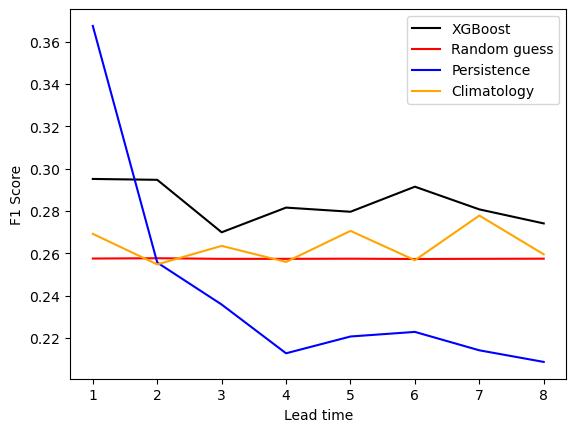

In [23]:
plt.plot(np.arange(1,9),f1s_test2[1:],color='k',label='XGBoost')
plt.plot(np.arange(1,9),f1s_random2[1:],color='red',label='Random guess')
plt.plot(np.arange(1,9),f1s_persistence2[1:],color='blue',label='Persistence')
plt.plot(np.arange(1,9),f1s_climatology2[1:],color='orange',label='Climatology')
plt.legend()
plt.ylabel('F1 Score')
plt.xlabel('Lead time')

Text(0.5, 0, 'Lead time')

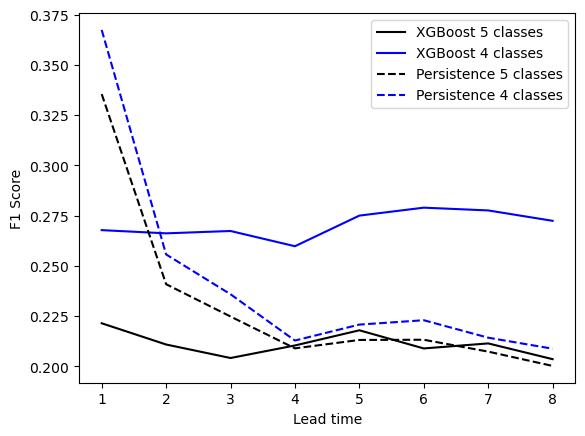

In [143]:
plt.plot(np.arange(1,9),f1s_test[1:],color='k',label='XGBoost 5 classes')
plt.plot(np.arange(1,9),f1s_test2[1:],color='blue',label='XGBoost 4 classes')

plt.plot(np.arange(1,9),f1s_persistence[1:],color='k',label='Persistence 5 classes',ls='--')
plt.plot(np.arange(1,9),f1s_persistence2[1:],color='blue',label='Persistence 4 classes',ls='--')

plt.legend()
plt.ylabel('F1 Score')
plt.xlabel('Lead time')

Text(0.5, 0, 'Lead time')

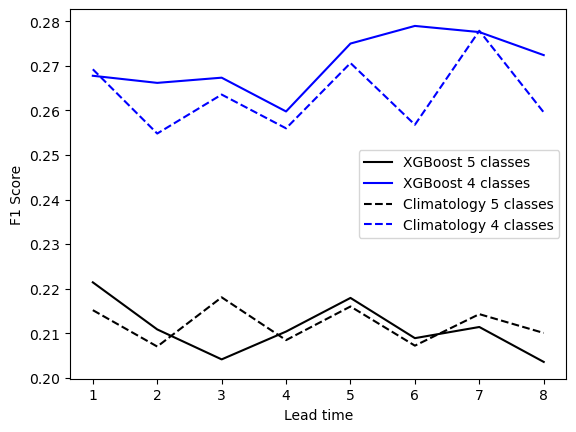

In [144]:
plt.plot(np.arange(1,9),f1s_test[1:],color='k',label='XGBoost 5 classes')
plt.plot(np.arange(1,9),f1s_test2[1:],color='blue',label='XGBoost 4 classes')

plt.plot(np.arange(1,9),f1s_climatology[1:],color='k',label='Climatology 5 classes',ls='--')
plt.plot(np.arange(1,9),f1s_climatology2[1:],color='blue',label='Climatology 4 classes',ls='--')

plt.legend()
plt.ylabel('F1 Score')
plt.xlabel('Lead time')